# Implements Rating Prediction Using Linear Regression

*Author*: Stella Zarei
*Created*: March 31st, 2025

### Import Util Functions

In [1]:
import os
import sys

# Import utils from subfolder of project, works for immediate subfolders of PROJECT_ROOT
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..')) # adjust relative import as necessary
sys.path.append(PROJECT_ROOT)
from utils.data_processing import get_filtered_review_data, get_metadata, compute_user_bias

### Import the Reviews and Metadata Datasets

In [2]:
# Fetch training, validation and test data
SELECTED_CATEGORY = 'Video_Games'
SELECTED_COLUMNS = ['user_id', 'product_id', 'parent_asin', 'title', 'text']

X_train, y_train, X_val, y_val, X_test, y_test = get_filtered_review_data(
    category=SELECTED_CATEGORY, 
    min_interactions=10,
    include_columns=SELECTED_COLUMNS
)
metadata = get_metadata(SELECTED_CATEGORY)

print("Metadata shape: " + str(metadata.shape))
print("Metadata columns: " + str(metadata.columns))

print("Training data shape: " + str(X_train.shape))
print("Training data columns: " + str(X_train.columns))

print("Validation data shape: " + str(X_val.shape))
print("Test data shape: " + str(X_test.shape))

Loading preprocessed data from data/Video_Games_min10_testfrac0.20_cols['user_id', 'product_id', 'parent_asin', 'title', 'text'].pkl
Loading metadata from data/Video_Games_metadata.pkl
Metadata shape: (137269, 11)
Metadata columns: Index(['main_category', 'title', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'store', 'categories', 'details',
       'parent_asin'],
      dtype='object')
Training data shape: (149876, 5)
Training data columns: Index(['user_id', 'product_id', 'parent_asin', 'title', 'text'], dtype='object')
Validation data shape: (23316, 5)
Test data shape: (23316, 5)


## Normalize Based on User Bias

This need only apply to the training examples

In [3]:
y_bias, user_bias = compute_user_bias([X_train, X_val], [y_train, y_val])

y_train_bias = y_bias[0]
y_val_bias = y_bias[1]

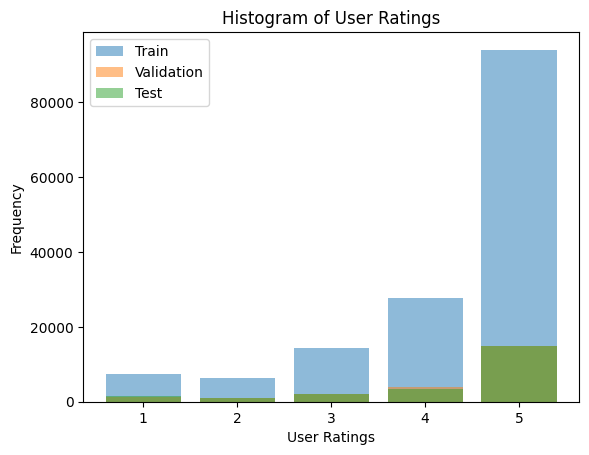

In [4]:
# Plot a histogram of the user ratings
import matplotlib.pyplot as plt
import numpy as np

y_train_orig = y_train * 4 + 1
y_val_orig = y_val * 4 + 1
y_test_orig = y_test * 4 + 1

bins = np.arange(0.5, 6.5, 1)  # from 0.5 to 6.0 (to include 5)

plt.hist(y_train_orig, bins=bins, rwidth=0.8, align='mid', alpha=0.5, label='Train')
plt.hist(y_val_orig, bins=bins, rwidth=0.8, align='mid', alpha=0.5, label='Validation')
plt.hist(y_test_orig, bins=bins, rwidth=0.8, align='mid', alpha=0.5, label='Test')

plt.xlabel('User Ratings')
plt.ylabel('Frequency')
plt.title('Histogram of User Ratings')
plt.xticks([1, 2, 3, 4, 5])
plt.legend()
plt.show()

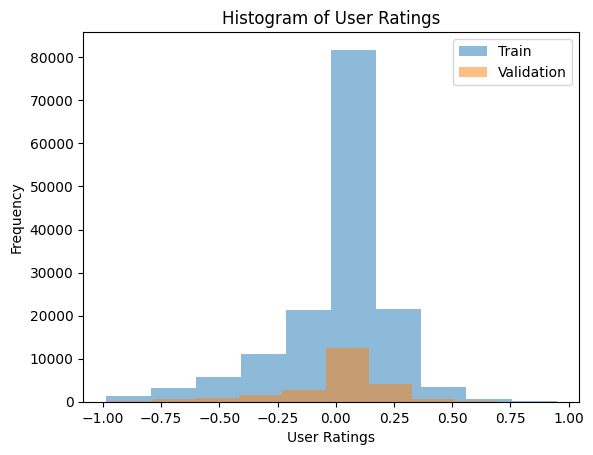

In [5]:
# Plot a histogram of the user ratings
import matplotlib.pyplot as plt

plt.hist(y_train_bias, bins=10, alpha=0.5, label='Train')
plt.hist(y_val_bias, bins=10, alpha=0.5, label='Validation')
plt.xlabel('User Ratings')
plt.ylabel('Frequency')
plt.title('Histogram of User Ratings')
plt.legend()
plt.show()

### Import Product Embeddings from natural-language-processing Directory

In [6]:
# read metadata embeddings from file
import pickle
import pandas as pd
slice_list = []

for i in range(0, 5):
    with open (os.path.join(PROJECT_ROOT, 'natural-language-processing/description-embeddings', f'slice-{i}.pkl'), 'rb') as f:
        data = pickle.load(f)
        df = pd.DataFrame(data)
        slice_list.append(df)

# concatenate all slices
embedding_df = pd.concat(slice_list, ignore_index=True)

# modify index of embedding_df to match metadata['parent_asin']
embedding_df.index = metadata['parent_asin'].tolist()
embedding_df.index.name = 'parent_asin'

print(embedding_df.shape)
print(embedding_df.head())

(137269, 384)
                  0         1         2         3         4         5    \
parent_asin                                                               
B000FH0MHO  -0.005333  0.007172 -0.048593 -0.036893 -0.044139  0.030708   
B00069EVOG  -0.118838  0.048299 -0.002548 -0.011011  0.051951  0.010292   
B00Z9TLVK0  -0.035121  0.052389 -0.006503 -0.148511  0.003149 -0.006528   
B07SZJZV88  -0.118838  0.048299 -0.002548 -0.011011  0.051951  0.010292   
B002WH4ZJG  -0.080119 -0.035443 -0.041519 -0.050098  0.013094  0.065544   

                  6         7         8         9    ...       374       375  \
parent_asin                                          ...                       
B000FH0MHO   0.020790  0.124238 -0.079286  0.038286  ...  0.007196  0.022913   
B00069EVOG   0.115433  0.000701 -0.085925 -0.070654  ...  0.107304  0.011428   
B00Z9TLVK0  -0.022535 -0.038059  0.031254  0.096640  ...  0.135246 -0.000769   
B07SZJZV88   0.115433  0.000701 -0.085925 -0.070654  ...  0.

# Get Frequency of Ratings for Each User

the data set is heavily skewed towards 5 star ratings (1.0)<br>
to address this we need to find the frequency of each response type for each user in the training data.<br>
we can use the frequency to scale the embeddings.<br>
for example if user x has the following reviews: [1, 1, 0, 2, 3]

then the embedding for each item is scaled by 1/(frequency of rating)

In [29]:
# dictionary of user_id key and list of 5 as value
user_rating_frequency = {}

# for each user_id in X_train, find the number of 0.2, 0.4, 0.6, 0.6, 1.0 ratings
for i in range(len(X_train)):
    user_id = X_train['user_id'].iloc[i]
    rating = y_train.iloc[i]
    if user_id not in user_rating_frequency:
        user_rating_frequency[user_id] = [0, 0, 0, 0, 0]
    if rating == 0.0:
        user_rating_frequency[user_id][0] += 1
    elif rating == 0.25:
        user_rating_frequency[user_id][1] += 1
    elif rating == 0.5:
        user_rating_frequency[user_id][2] += 1
    elif rating == 0.75:
        user_rating_frequency[user_id][3] += 1
    elif rating == 1.0:
        user_rating_frequency[user_id][4] += 1

print(y_train.unique())

[1.   0.75 0.5  0.25 0.  ]


In [30]:
user_rating_frequency[9222]

[0, 0, 0, 0, 19]

### Learn User Preferences Using Linear Regression

For each user $u_j$ find vector $\theta_j$ that best approximates the users preference <br><br>

$\theta_j$ that minimizes $$1/2 \sum_{x_i \in R(u_j)} ((\theta_j \cdot x_i) - y_{i,j})^2$$ 

Where $x_i$ is a product embedding<br>
$R(u_j)$ the set of products rated by $u_j$<br>
$y_{i,j}$ is the rating given to product $x_i$ by user $u_j$ <br>

### Adjust for Dataset Bias
scale product vector $x_i$ by the frequency of the label 

$\theta_j$ that minimizes $$1/2 \sum_{x_i \in R(u_j)} ((\theta_j \cdot \alpha x_i) - y_{i,j})^2$$ 
where $\alpha = 1 / frequencyOfLabel$ 

### Uses Scikit Learn Ridge Model for Linear Regression
This model solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm. 

In [38]:
import numpy as np
from sklearn.linear_model import Ridge

# user preferences described by theta and intercept
learned_preferences = {}

for user_id in X_train['user_id'].unique():
    # mask for current user
    user_mask = X_train['user_id'] == user_id
    product_rated_by_user = X_train[user_mask]['parent_asin'].tolist()
    rating_by_user = y_train_bias[user_mask]

    


    # get the embeddings for 
    product_embeddings = [ embedding_df.loc[pid].values for pid in product_rated_by_user ]
    true_ratings = rating_by_user.tolist()

    # scale each product embedding by 1/user_rating_frequency[user_id][0]
    rating_before_bias = y_train[user_mask].tolist()
    for i in range(len(product_embeddings)):
        if rating_before_bias[i] == 0.0:
            product_embeddings[i] = product_embeddings[i] * (1/user_rating_frequency[user_id][0])
        elif rating_before_bias[i] == 0.25: 
            product_embeddings[i] = product_embeddings[i] * (1/user_rating_frequency[user_id][1])
        elif rating_before_bias[i] == 0.5:
            product_embeddings[i] = product_embeddings[i] * (1/user_rating_frequency[user_id][2])
        elif rating_before_bias[i] == 0.75:
            product_embeddings[i] = product_embeddings[i] * (1/user_rating_frequency[user_id][3])
        elif rating_before_bias[i] == 1.0:
            product_embeddings[i] = product_embeddings[i] * (1/user_rating_frequency[user_id][4])
        else:
            print(f"Warning: user {user_id} has no ratings of {true_ratings[i]}")

    # learn user preference
    model = Ridge()
    model.fit(product_embeddings, true_ratings)

    # store learned preference
    learned_preferences[user_id] = {'theta' : model.coef_, 'intercept' : model.intercept_}


### Use Learned Preference to Determine Training Error

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = []
y_pred = []

for idx, row in X_train.iterrows():
    user_id = row.user_id
    product_id = row.parent_asin

    if user_id not in learned_preferences or product_id not in embedding_df.index:
        continue

    actual_rating = y_train_bias[idx] + user_bias[user_id]
    theta = learned_preferences[user_id]['theta']
    intercept = learned_preferences[user_id]['intercept']
    embedding = embedding_df.loc[product_id].values

    predicted_rating = np.dot(theta, embedding) + intercept 
    predicted_rating += user_bias[user_id]
    predicted_rating = np.clip(predicted_rating, 0, 1)

    y_true.append(actual_rating)
    y_pred.append(predicted_rating)

# Metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

MSE: 0.0399, MAE: 0.1464


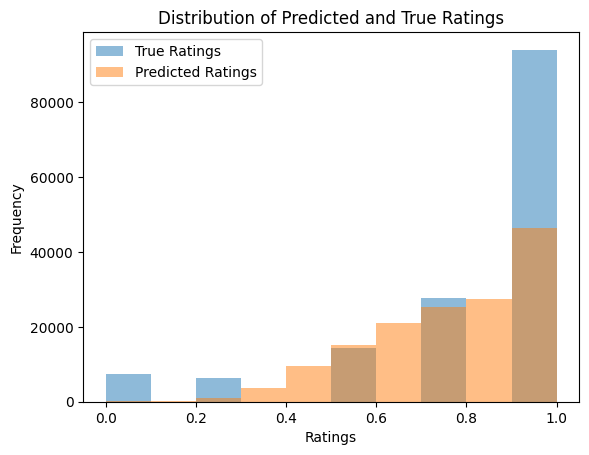

In [ ]:
# Plot the distribution of predicted ratings
plt.hist(y_true, bins=10, alpha=0.5, label='True Ratings')
plt.hist(y_pred, bins=10, alpha=0.5, label='Predicted Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted and True Ratings')
plt.legend()
plt.show()

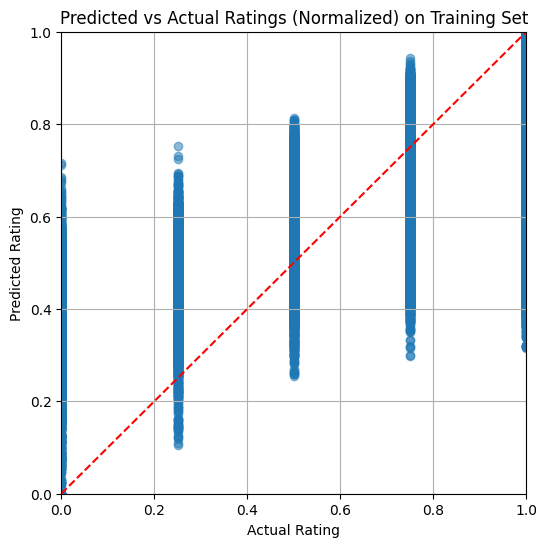

In [ ]:
# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Predicted vs Actual Ratings (Normalized) on Training Set")
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [42]:
# print average user bias
print("Average user bias: " + str(np.mean(user_bias)))

Average user bias: 0.8292960071985751


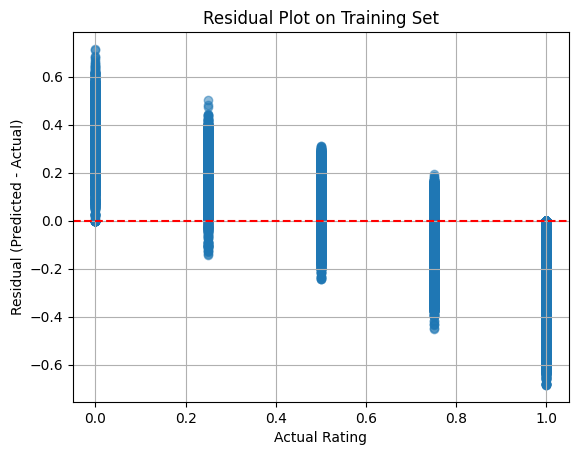

In [ ]:
import matplotlib.pyplot as plt

residuals = np.array(y_pred) - np.array(y_true)

plt.scatter(y_true, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual Rating")
plt.ylabel("Residual (Predicted - Actual)")
plt.title("Residual Plot on Training Set")
plt.grid(True)
plt.show()

### Use the Learned Preferences to Predict Test Cases

In [56]:
y_true = []
y_pred = []

for idx, row in X_test.iterrows():
    user_id = row.user_id
    product_id = row.parent_asin

    if user_id not in learned_preferences or product_id not in embedding_df.index:
        continue

    actual_rating = y_test[idx]
    theta = learned_preferences[user_id]['theta']
    intercept = learned_preferences[user_id]['intercept']
    embedding = embedding_df.loc[product_id].values

    predicted_rating = np.dot(theta, embedding) + intercept 
    # add user bias
    predicted_rating += user_bias[user_id]
    predicted_rating = np.clip(predicted_rating, 0, 1)

    y_true.append(actual_rating)
    y_pred.append(predicted_rating)

# Metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

MSE: 0.0790, MAE: 0.1919


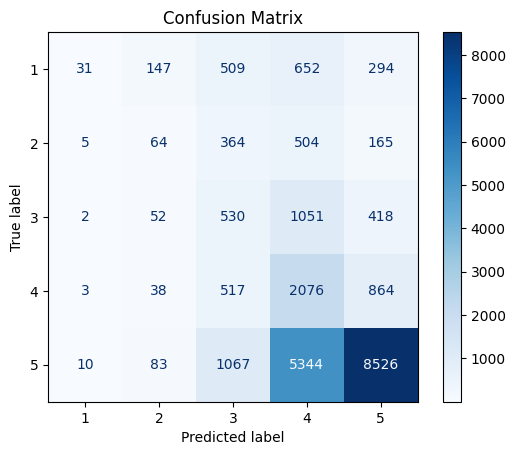

In [57]:
# use y_true and y_pred to plot a confusion matrix

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

# Convert to numpy arrays
y_true_np = np.array(y_true)
y_pred_np = np.array(y_pred)

# Convert to original ratings
y_true_np = np.round(y_true_np * 4 + 1)
y_pred_np = np.round(y_pred_np * 4 + 1)

# Create confusion matrix
cm = confusion_matrix(y_true_np, y_pred_np, labels=[1, 2, 3, 4, 5])
cm_display = ConfusionMatrixDisplay(cm, display_labels=[1, 2, 3, 4, 5])
cm_display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


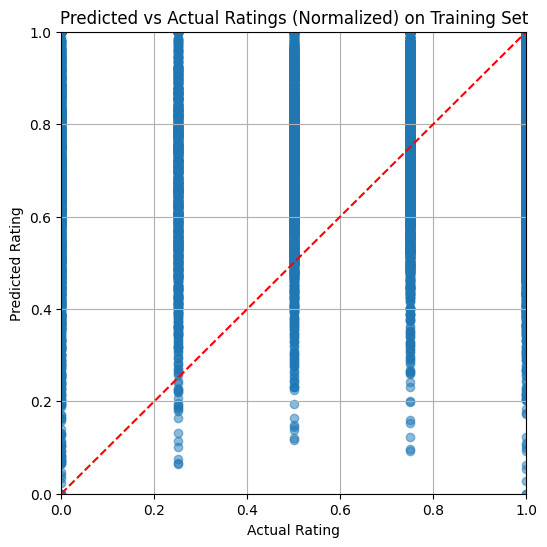

In [58]:
# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Predicted vs Actual Ratings (Normalized) on Training Set")
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

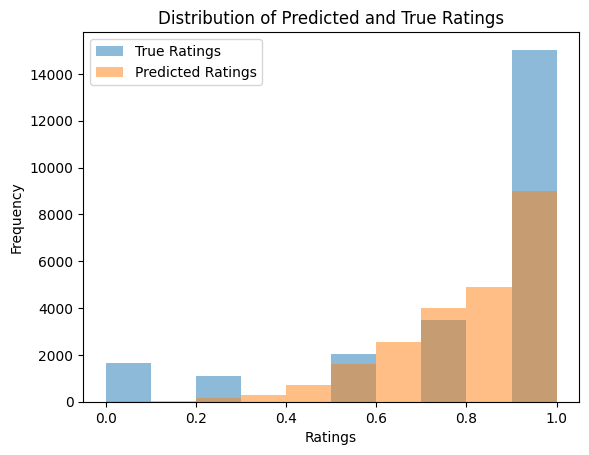

In [59]:
plt.hist(y_true, bins=10, alpha=0.5, label='True Ratings')
plt.hist(y_pred, bins=10, alpha=0.5, label='Predicted Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted and True Ratings')
plt.legend()
plt.show()